# 5.1- NLP

NLP trata de aplicaciones que entiendan nuestro idioma, reconocimiento de voz, traducción, comprensión semántica, análisis de sentimiento..

**Usos**

+ Motores de búsqueda
+ Feed de redes sociales
+ Asistentes de voz 
+ Filtros de span
+ Chatbots

**Librerías**

+ NLTK
+ Spacy
+ TFIDF
+ OpenNLP

La dificultad del NLP está en varios niveles:

+ Ambigüedad:

  * Nivel léxico: por ejemplo, varios significados
  * Nivel referencial: anáforas, metáforas, etc...
  * Nivel estructural: la semántica es necesaria para entender la estructura de una oración
  * Nivel pragmático: dobles sentidos, ironía, humor
  
+ Detección de espacios
+ Recepción imperfecta: acentos, -ismos, OCR

El proceso es similar que en USL, primero se vectorizan las palabras y después se miden sus distancias/similitudes. 

In [ ]:
# lista de 100 peliculas

titles=open('../data/title_list.txt').read().split('\n')[:100]

titles[:10]

In [ ]:
synopsis=open('../data/synopses_list.txt').read().split('\n BREAKS HERE')[:100]

synopsis[0][:1000]

### Limpieza

In [ ]:
#!pip install spacy

In [1]:
import string

import spacy

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import re

In [ ]:
#!python -m spacy download en_core_web_sm

In [ ]:
nlp=spacy.load('en_core_web_sm')

parser=English()

In [13]:
def spacy_tokenizer(sentence):
    
    tokens=parser(sentence)

    filtered_tokens=[]
    for word in tokens:

        lemma=str(word).lower().strip()

        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)
            
    return filtered_tokens

In [ ]:
spacy_tokenizer(synopsis[0][:200])

### TFIDF (term frequency inverse document frequency)

In [ ]:
type(synopsis)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf=TfidfVectorizer(min_df=0.15, tokenizer=spacy_tokenizer)

In [ ]:
tfidf_matrix=tfidf.fit_transform(synopsis)

In [ ]:
tfidf_matrix.shape

In [ ]:
import pandas as pd

pd.DataFrame(tfidf_matrix).to_csv('../data/tfidf_matrix.csv')

pd.DataFrame(tfidf_matrix).head()

In [ ]:
terms=tfidf.get_feature_names()

terms[:15]

### Distancias

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cos

In [ ]:
dist=1-cos(tfidf_matrix)

dist=pd.DataFrame(dist)

dist.shape

In [ ]:
dist.to_csv('../data/dist.csv')

### Clustering

In [ ]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

import numpy as np
import pandas as pd

In [ ]:
from umap import UMAP

In [ ]:
dist=pd.read_csv('../data/dist.csv')
tfidf_matrix=pd.read_csv('../data/tfidf_matrix.csv')

In [ ]:
umap=UMAP(n_neighbors=5, random_state=42)
emb=umap.fit_transform(dist)

In [ ]:
emb.shape

In [ ]:
plt.scatter(emb[:,0], emb[:,1]);

In [ ]:
from hdbscan import HDBSCAN

In [ ]:
hdbscan=HDBSCAN(min_cluster_size=5)

clusters=hdbscan.fit_predict(emb)

In [ ]:
np.unique(clusters)

In [ ]:
plt.scatter(emb[:,0], emb[:,1], c=clusters);

### titulos de los clusters

In [ ]:
def get_titles_from_cluster(c):
    return pd.Series(titles)[clusters==c]

In [ ]:
get_titles_from_cluster(3)

## NLP_es 

In [ ]:
#!python -m spacy download es_core_news_md

In [2]:
nlp=spacy.load('es_core_news_md')

In [4]:
doc2vec=nlp('hola me llamo pape').vector.sum()


doc2vec

-19.978054

In [5]:
word2vec=(nlp('hola').vector + nlp('me').vector + nlp('llamo').vector + nlp('pape').vector).sum()/4

word2vec

-19.97805404663086

##### similitud

In [11]:
nlp('quiero saludar a todos los alumnos').similarity(nlp('quiero saludar todos alumnos'))

0.7821918620834944

In [20]:
parser=Spanish()

tokens_1=spacy_tokenizer('quiero saludar a todos')

tokens_2=spacy_tokenizer('saludos al perro')

In [21]:
def get_simil(t1, t2):
    return nlp(' '.join(t1)).similarity(nlp(' '.join(t2)))

In [22]:
get_simil(tokens_1, tokens_2)

0.26943539180268417

# WordClouds

In [ ]:
#!pip install langdetect
#!pip install wordcloud

In [23]:
# librerias

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from spacy.lang.es import Spanish



import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_sp=set(stopwords.words('spanish'))
stop_words_en=set(stopwords.words('english'))
stop_words=stop_words_sp | stop_words_en


import re

from langdetect import detect

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /Users/iudh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def tokenizer(txt):  # texto
    
    if detect(txt)=='en':    # si el texto esta en ingles...
        nlp=spacy.load('en_core_web_sm')
        parser=English()
        
    elif detect(txt)=='es':   # si el texto esta en castellano...
        nlp=spacy.load('es_core_news_md')
        parser=Spanish()
        
    else:
        return 'No es castellano ni ingles.'
    
    tokens=parser(txt)
    
    filtered_tokens=[]
    
    for word in tokens:
        lemma=word.lemma_.lower().strip()
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)
    
    return ' '.join(filtered_tokens)

In [30]:
def wordcloud(df, col):
    
    wordcloud=WordCloud(width=1600,
                        height=400,
                        stopwords=stop_words).generate(' '.join([e for e in df[col]]))
    
    plt.figure(figsize=(15, 10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig('images/wordcloud.png', facecolor='k', bbox_inches='tight')
    plt.show();

In [31]:
# texto

txt=open('../data/synopses_list.txt').read().split('\n BREAKS HERE')[:100]

In [37]:
df=pd.DataFrame(txt, columns=['text'])

df.text=df.text.apply(spacy_tokenizer)

df.head()

,text
0,"[plot, edit, edit, edit, day, wedding, vito, c..."
1,"[plot, edit, edit, edit, banker, andy, dufresn..."
2,"[plot, edit, edit, edit, germans, polish, jews..."
3,"[plot, edit, edit, edit, brief, scene, aging, ..."
4,"[plot, edit, edit, edit, early, december, amer..."


In [38]:
df.text=df.text.apply(lambda x: ' ,'.join(x))

df.head()

,text
0,"plot ,edit ,edit ,edit ,day ,wedding ,vito ,co..."
1,"plot ,edit ,edit ,edit ,banker ,andy ,dufresne..."
2,"plot ,edit ,edit ,edit ,germans ,polish ,jews ..."
3,"plot ,edit ,edit ,edit ,brief ,scene ,aging ,o..."
4,"plot ,edit ,edit ,edit ,early ,december ,ameri..."


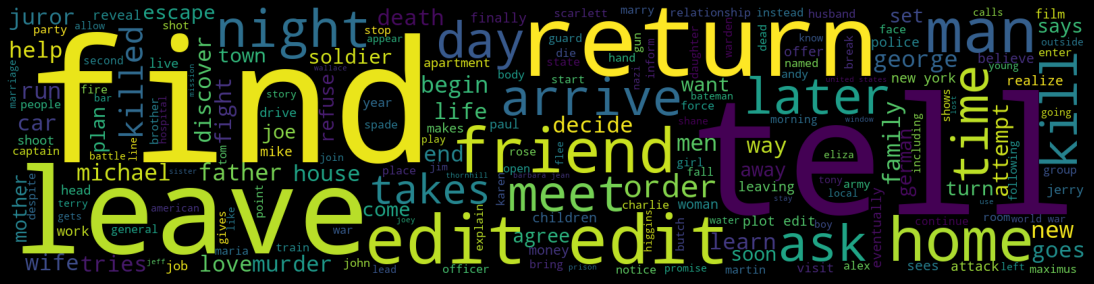

In [39]:
# wordcloud

wordcloud(df, 'text')

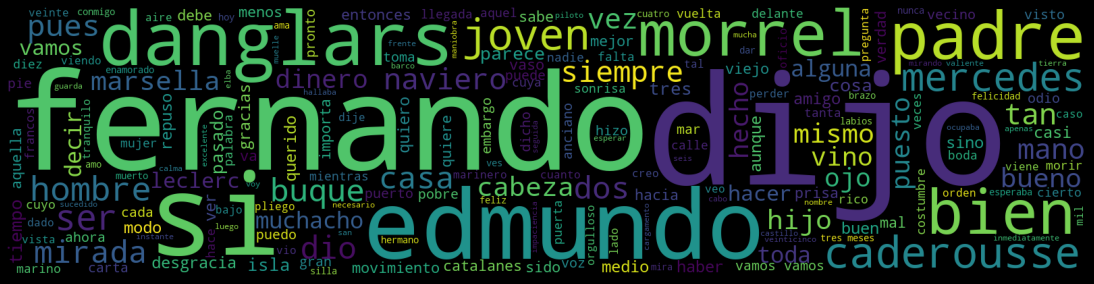

In [40]:
# en castellano

txt2=open('../data/conde.txt').read().split('\n BREAKS HERE')[:100]

df2=pd.DataFrame(txt2, columns=['text'])

df2.text=df2.text.apply(spacy_tokenizer)

df2.text=df2.text.apply(lambda x: ' ,'.join(x))

wordcloud(df2, 'text')

#### Mascara

In [42]:
# imagen mascara

vino_mask=np.array(Image.open('images/vino.png'))

In [47]:
vino_mask.shape

(512, 512)

In [44]:
# transformacion de la mascara, poner en negativo

def transform(val):
    if val==0:
        return 255
    else:
        return val

In [45]:
t_vino_mask=np.ndarray((vino_mask.shape[0], vino_mask.shape[1]), np.int32)


for i in range(len(vino_mask)):
    t_vino_mask[i]=list(map(transform, vino_mask[i]))

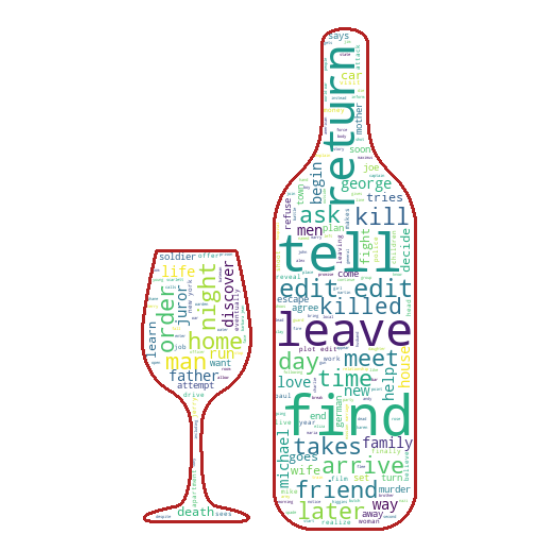

In [46]:
w=WordCloud(background_color='white',
            max_words=1000,
            mask=t_vino_mask,
            stopwords=stop_words,
            contour_width=3,
            contour_color='firebrick').generate(' '.join([e for e in df.text]))


w.to_file('images/copa&botella.png')

plt.figure(figsize=(15, 10))
plt.imshow(w, interpolation='bilinear')
plt.axis('off')
plt.show();

## NER

In [48]:
news=pd.read_csv('../data/noticias.csv')

news.head()

,url,authors,title,publish_date,text,top_image,keywords,summary,video,polarity,subjectivity,negativity,neutrality,positivity,compound_score
0,http://epaper.lavanguardia.com/la-vanguardia/l...,[],14 de agosto de 2020,2020-08-14 00:00:00,"Segunda\n\nTodo sobre Kamala Harris En 1970, c...",http://static.milibris.com/thumbnail/issue/9d8...,"[""14"", ""2020"", ""agosto""]",Postal: ciudad zombi La preocupación por la ag...,[],0.031507,0.381115,0.020,0.960,0.021,-0.1048
1,http://epaper.lavanguardia.com/la-vanguardia/l...,[],13 de septiembre de 2020,2020-09-13 00:00:00,Segunda\n\nEl papel no quiere morir Una notici...,http://static.milibris.com/thumbnail/issue/876...,"[""septiembre"", ""2020"", ""13""]",El honor de la familia se ha desplazado del vi...,[],0.090058,0.451170,0.025,0.955,0.020,-0.9705
2,http://epaper.lavanguardia.com/la-vanguardia/l...,[],15 de julio de 2020,2020-07-15 00:00:00,Segunda\n\nPrivacidad en peligro Existe una em...,http://static.milibris.com/thumbnail/issue/cce...,"[""julio"", ""2020"", ""15""]",Los estudiantes internacionales matriculados e...,[],0.076812,0.416667,0.025,0.957,0.018,-0.9798
3,https://club.lavanguardia.com/es/ocio-cultura/...,[],Descuento PortAventura,NaN,Presenta tu tarjeta del Club en taquillas\n\n3...,https://club.lavanguardia.com/sites/default/fi...,"[""world"", ""descuento"", ""portaventura"", ""tarjeta""]",Presenta tu tarjeta del Club en taquillas35% d...,"[""https://www.youtube.com/embed/oqXl8CLaHdY""]",0.100000,0.100000,0.040,0.960,0.000,-0.7783
4,http://epaper.lavanguardia.com/la-vanguardia/l...,[],1 de febrero de 2021,2021-02-01 00:00:00,Portada\n\nSalut defiende prolongar las restri...,http://static.milibris.com/thumbnail/issue/d7c...,"[""febrero"", ""2021""]",Sostiene que el PP genera progreso allí donde ...,[],0.057292,0.425556,0.021,0.957,0.022,-0.5686


In [49]:
import spacy
from spacy import displacy

In [ ]:
#!python -m spacy download es_core_news_lg

In [ ]:
#!python -m spacy download en_core_web_lg

In [50]:
spacy_core_es='es_core_news_lg'

spacy_core_en='en_core_web_lg'

In [51]:
def ner(spacy_core, data):
    
    nlp=spacy.load(spacy_core)
    
    sentencias=list(nlp(data).sents)
    
    entidades=displacy.render(nlp(str(sentencias)), style='ent')
    
    return entidades

In [55]:
ner(spacy_core_es, news.text[150])

In [59]:
ner(spacy_core_en, txt[0][:1000])

### Transformers (creacion de texto)

In [ ]:
#!pip install transformers

In [ ]:
#!pip install tensorflow
#!pip install torch

In [62]:
from transformers import pipeline

generador=pipeline('text-generation', model='EleutherAI/gpt-neo-125M')

In [63]:
def crea_texto(generador, texto, min_long=100):
    return generador(texto, do_sample=True, min_length=min_long)[0]['generated_text']

In [67]:
crea_texto(generador, 'data science is')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'data science is now available to scientists who need your advice. We can find the best books, and'

In [65]:
crea_texto(generador, 'what is this')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'what is this? It\'s not important if its not." _"The story it tells is just'

In [70]:
crea_texto(generador, 'what planet is this', 1000)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'what planet is this, or in, or even better, a planet! This makes it the site'